## Using Copernicus Digital Elevation Model (DEM) data 

Adapted from https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/copernicus-dem/copernicus-dem-example.ipynb

The Copernicus digital elevation model is derived from the WorldDEMTM digital surface model based on the radar satellite data acquired during the TanDEM-X Mission. terrabyte hosts these data with the original GeoTIFFs in two resolutions, 90m (`cop-dem-glo-90`) and 30m (`cop-dem-glo-30`).

For this example, we will find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [1]:
import pystac_client
from odc import stac as odc_stac

catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
collection = 'cop-dem-glo-90'

catalog = pystac_client.Client.open(
    catalog_url
)

Perform a STAC API query against the finer resolution `cop-dem-glo-30` collection for our point of interest. 

In [2]:
grand_canyon = [-112.15, 36.05]
search = catalog.search(
    collections=[collection],
    intersects={"type": "Point", "coordinates": grand_canyon},
)
items = list(search.items())
print(f"Returned {len(items)} items")

Returned 1 items


A single item was returned which includes the elevation data and additional assets for quick visualization.

In [3]:
list(items[0].assets)

['ql',
 'acm',
 'dem',
 'edm',
 'flm',
 'hem',
 'src',
 'wbm',
 'dem_ql',
 'edm_ql',
 'flm_ql',
 'hem_ql',
 'wbm_ql',
 'dem_abs_ql']

We load the data from STAC and remove the unneedet time Dimension

In [4]:
cube = (odc_stac.load(items)
       .squeeze()
       .drop("time"))
cube

<xarray.Dataset>
Dimensions:      (latitude: 1202, longitude: 1202)
Coordinates:
  * latitude     (latitude) float64 37.0 37.0 37.0 37.0 ... 36.0 36.0 36.0 36.0
  * longitude    (longitude) float64 -113.0 -113.0 -113.0 ... -112.0 -112.0
    spatial_ref  int32 4326
Data variables:
    dem          (latitude, longitude) float32 nan 1.539e+03 ... nan nan
    edm          (latitude, longitude) uint8 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    flm          (latitude, longitude) uint8 0 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0
    hem          (latitude, longitude) float32 nan 0.7137 0.7137 ... nan nan nan
    wbm          (latitude, longitude) uint8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dem_ql       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    edm_ql       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    flm_ql       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    hem_ql       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    wbm_ql       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    dem_abs_ql   (latitude, longitude) float32 nan nan nan nan ... nan nan nan

With the data loaded, we can use `xarray-spatial` to generate a shaded relief.

/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


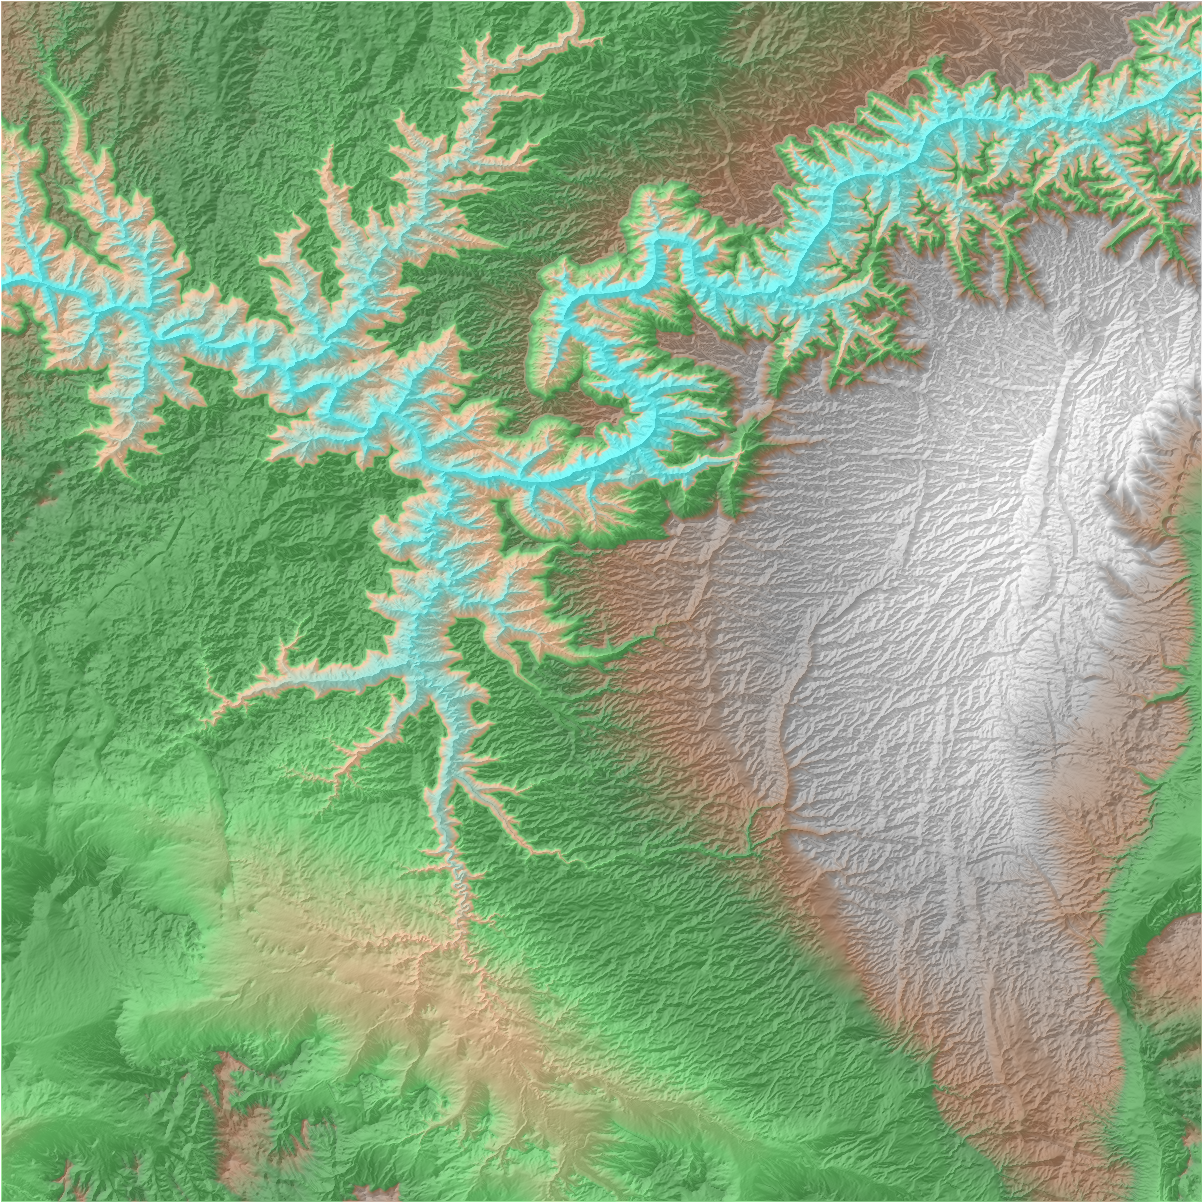

In [5]:
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(cube.dem)
stack(shade(hillshade, cmap=["white", "gray"]), shade(cube.dem, cmap=Elevation, alpha=128))